In [1]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
lidar_dir = "../Huawei/dataset/sequences/03/velodyne"

In [3]:
points = np.fromfile(f"{lidar_dir}/000005.bin", dtype=np.float32).reshape(-1, 4)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points[:, :3])

In [4]:
lower_mask = (points[:, 2] < -1) & (points[:, 2] > -2) & (points[:, 0] > 0) & (points[:, 0] < 15)
lower_mask.shape

(46080,)

In [5]:
from scipy.spatial import KDTree

# Build a KD-tree for fast nearest neighbor search
tree = KDTree(points[:, :2])  # Only use (X, Y) for search

curb_threshold = 0.1 # Height difference to detect curbs
curb_idxs = []

for i, pt in zip(np.where(lower_mask)[0], points[lower_mask]):
    # Find neighbors within 0.5m radius
    idx = tree.query_ball_point(pt[:2], 0.5)
    neighbors = points[idx]

    # Compute height difference with neighbors
    height_diffs = np.abs(neighbors[:, 2] - pt[2])

    if np.max(height_diffs) > curb_threshold:
        curb_idxs.append(i)

curb_init_idxs = np.array(curb_idxs)
curb_idxs = np.concatenate([curb_init_idxs, np.where(~lower_mask)[0]])


In [6]:
inlier_cloud = pcd.select_by_index(curb_idxs, invert=True)
outlier_cloud = pcd.select_by_index(curb_idxs, invert=False)
outlier_cloud.paint_uniform_color([1.0, 0, 0.0])

PointCloud with 39454 points.

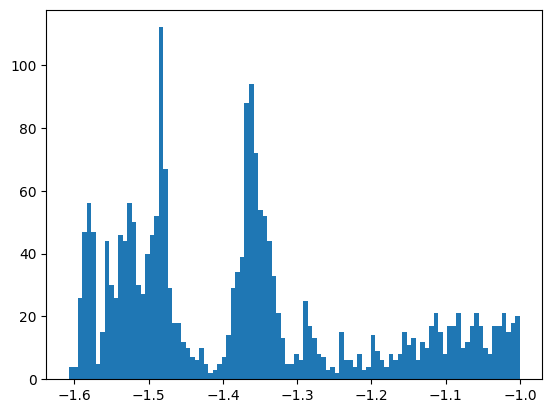

In [7]:
plt.hist(points[curb_init_idxs][:, 2],100);

In [8]:
curb_height = np.median(points[curb_init_idxs][:, 2])
curb_height

-1.3758804

In [9]:
road_ind = np.where(np.asarray(inlier_cloud.points)[:, 2] <= curb_height)[0]
road_cloud = inlier_cloud.select_by_index(road_ind)
pavement_cloud = inlier_cloud.select_by_index(road_ind, invert=True)

In [10]:
o3d.visualization.draw_geometries(
    [road_cloud, pavement_cloud],
    zoom=0.05,
    front=[-0.1, -0.0, 0.1],
    lookat=[2.1813, 2.0619, 2.0999],
    up=[0.0, -0.0, 1.0],
)

In [11]:
road_pts = np.asarray(road_cloud.points)
pavement_pts = np.asarray(pavement_cloud.points)

coef_road = np.linalg.lstsq(np.concatenate([road_pts[:,:2], np.ones((road_pts.shape[0], 1))], axis=1), road_pts[:,2])[0]
coef_pave = np.linalg.lstsq(np.concatenate([pavement_pts[:,:2], np.ones((pavement_pts.shape[0], 1))], axis=1), pavement_pts[:,2])[0]
coef_road, coef_pave

/tmp/ipykernel_172985/3249074590.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_road = np.linalg.lstsq(np.concatenate([road_pts[:,:2], np.ones((road_pts.shape[0], 1))], axis=1), road_pts[:,2])[0]
/tmp/ipykernel_172985/3249074590.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef_pave = np.linalg.lstsq(np.concatenate([pavement_pts[:,:2], np.ones((pavement_pts.shape[0], 1))], axis=1), pavement_pts[:,2])[0]


(array([-0.0085493 , -0.01855514, -1.42784415]),
 array([ 8.41437972e-04,  4.21889828e-03, -1.29188395e+00]))

In [12]:
road_res = np.concatenate([points[:,:2], np.ones((points.shape[0], 1))], axis=1) @ coef_road - points[:,2]
pavement_res = np.concatenate([points[:,:2], np.ones((points.shape[0], 1))], axis=1) @ coef_pave - points[:,2]

In [13]:
road_full_idxs = np.where((np.abs(road_res) < 0.1) & (np.abs(pavement_res) > 0.04))[0]
pave_full_idxs = np.where((np.abs(road_res) > 0.1) & (np.abs(pavement_res) < 0.04))[0]
out_full_idxs = np.where((np.abs(road_res) > 0.1) & (np.abs(pavement_res) > 0.04))[0]
uncert_full_idxs = np.where((np.abs(road_res) < 0.1) & (np.abs(pavement_res) < 0.04))[0]

In [14]:
road_cloud = pcd.select_by_index(road_full_idxs)
pavement_cloud = pcd.select_by_index(pave_full_idxs)
extra_out_cloud = pcd.select_by_index(out_full_idxs)
uncert_cloud = pcd.select_by_index(uncert_full_idxs)

In [15]:
road_cloud.paint_uniform_color([0.0, 0, 1.0])
pavement_cloud.paint_uniform_color([0.0, 1.0, 0.0])
extra_out_cloud.paint_uniform_color([1.0, 0.0, 0.0])
uncert_cloud.paint_uniform_color([0.0, 1.0, 1.0]);

In [16]:
o3d.visualization.draw_geometries(
    [road_cloud, pavement_cloud, uncert_cloud, extra_out_cloud],
    zoom=0.05,
    front=[-0.1, -0.0, 0.1],
    lookat=[2.1813, 2.0619, 2.0999],
    up=[0.0, -0.0, 1.0],
)